# SCALES filter options

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

Adjust minimum and maximum wavelength if we want to

In [5]:
arg_spaxel['min_wavelength'] = 2.9 #minimum wavelength in microns
arg_spaxel['max_wavelength'] = 4.15 #maximum wavelength in microns



## Set up lenslet traces

In [6]:
lens = Lenslet(arg_spaxel)
lens.get_shifts()
lens.make_trace(phys=False,verbose=True)



## Read in Keck pupil

In [7]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [8]:
screen = PhaseScreen(pupil=pupil, L0=10)
screen.sr_factor = screen.set_strehl(.8, 500e-9)
#screen1 = screen.get_res()
screen1 = np.zeros(screen.get_res().shape)

## Use pupil and residual phase to generate cube of Keck PSFs

In [9]:
nspax = arg_spaxel['no_spaxel']
nlam = lens.trace.shape[0]

keck_cube = np.zeros((nlam, nspax, nspax))
mag1 = magn(lens.lmin)
mag2 = magn(lens.lmax)

psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
if os.path.isfile(psf_file)==False:
    for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
        W = DFT_matrix(1600, mag)
        A = pupil.pupil * np.exp(1.j * screen1)
        out = abs(W.dot(A).dot(W))**2
        out /= np.sum(out, axis=(0,1))
        keck_cube[i] = frebin(out, (108, 108))
    fits.writeto(psf_file,np.array(keck_cube),clobber=True)
else: keck_cube = pyfits.getdata(psf_file)

## Define some observational parameters

-Reads in sky transmission and emission models provided by Gemini for MK site: https://www.gemini.edu/observing/telescopes-and-sites/sites#IRSky

-Reads in atmospheric dispersion data based on relative humidity, temperature, pressure, and airmass

-Instrument transmission & emission includes SCALES + AO emissivity

-Default QE is 70%

-For now set up perfect filter with tophat from lmin to lmax

-Define single frame integration time in seconds

In [10]:
vapor = 1 #PWV in mm
airmass = 1 
skybg = SkyBG(vapor,airmass)
skytrans = SkyTrans(vapor,airmass)
atmodisp = AtmoDispersion(90,20,600)
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)
qe = QE()
dit = 1 ###integration time in seconds

# Generate raw image and cube for "perfect" filter

In [11]:
#filt = Filter(fkw='andover',lmin=lens.lmin,lmax=lens.lmax)
#filt = Filter(fkw='asahi',lmin=lens.lmin,lmax=lens.lmax)
filt = Filter(fkw='filter_perfect',lmin=lens.lmin,lmax=lens.lmax)

####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

### Generate raw SCALES frame using  PSF (bkgd only)

In [12]:
rawfile = 'filter_tests/perfect/raw_'+str(lens.lmin)+'_'+str(lens.lmax)+'.fits'
if os.path.isfile(rawfile)==False:
    raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,PSF=keck_cube,verbose=True)
    pyfits.writeto(rawfile,np.array(raw),clobber=True)
else: raw = pyfits.getdata(rawfile)

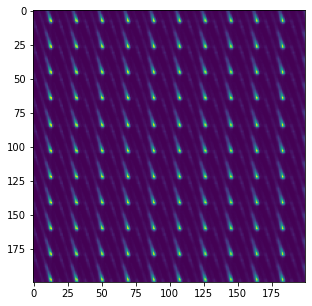

In [13]:
f = plt.figure(figsize=(5,5))
plt.imshow(raw[1200:1400,1200:1400])
plt.show()

## Cube up raw frame using simple aperture extraction - using trace on single spectrum... (need to generate more rectmats)

In [14]:
 def extract_using_trace(frame):
    poss = lens.args['spaxel_size_px'] * np.arange(fp.num_spaxel)
    cinds = np.where(np.abs(fp.lam.value - lens.lmin)<1.0e-6)[0][0]
    cinde = np.where(np.abs(fp.lam.value - lens.lmax)<1.0e-6)[0][0]
    dx = lens.xx[cinds]
    dy = lens.yy[cinds]
    ii = 54
    jj = 54
    npx = lens.trace[0].shape[1]/2
    npy = lens.trace[0].shape[0]/2
    xloc=(npx+dx)
    yloc=(npy+dy)
    sdx = poss[ii]-xloc
    sdy = poss[jj]-yloc
    imy = int(sdy)
    imx = int(sdx)
    dimy = sdy - imy
    dimx = sdx - imx
    lamsx = fp.lam[cinds:cinde+1]
    toextr=lens.trace.copy()[cinds:cinde+1]
    specout = []
    for ll in range(len(toextr)):
        tinp = toextr[ll]
        toadd = np.zeros([tinp.shape[0]+2,tinp.shape[1]+2])
        dxt = len(toadd)
        dyt = len(toadd[0])
        toadd[1:1+len(tinp),1:1+len(tinp[0])] = np.array(tinp)
        toadd = shift(toadd,(dimy,dimx),order=1,prefilter=False)
        ones = np.zeros(toadd.shape)
        ones[np.where(toadd > np.max(toadd)*0.25)] = 1.0        
        specex = np.sum(frame[imy:imy+dyt,imx:imx+dxt]*toadd)
        specout.append([lamsx[ll].value,specex])
    return np.array(specout)

[2.9  2.91 2.92 2.93 2.94 2.95 2.96 2.97 2.98 2.99 3.   3.01 3.02 3.03
 3.04 3.05 3.06 3.07 3.08 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17
 3.18 3.19 3.2  3.21 3.22 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31
 3.32 3.33 3.34 3.35 3.36 3.37 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45
 3.46 3.47 3.48 3.49 3.5  3.51 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59
 3.6  3.61 3.62 3.63 3.64 3.65 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73
 3.74 3.75 3.76 3.77 3.78 3.79 3.8  3.81 3.82 3.83 3.84 3.85 3.86 3.87
 3.88 3.89 3.9  3.91 3.92 3.93 3.94 3.95 3.96 3.97 3.98 3.99 4.   4.01
 4.02 4.03 4.04 4.05 4.06 4.07 4.08 4.09 4.1  4.11 4.12 4.13 4.14 4.15] micron
(126, 2)


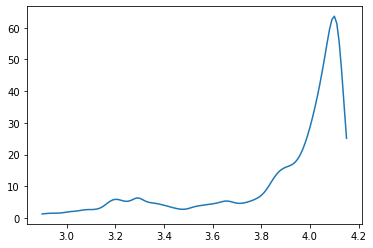

In [15]:
cinds = np.where(np.abs(fp.lam.value - lens.lmin)<1.0e-6)[0][0]
cinde = np.where(np.abs(fp.lam.value - lens.lmax)<1.0e-6)[0][0]
print(fp.lam[cinds:cinde+1])
specout = extract_using_trace(raw)
asf = 'filter_tests/perfect/ext_'+str(lens.lmin)+'_'+str(lens.lmax)+'.fits'
pyfits.writeto(asf,np.array(specout),clobber=True)
print(specout.shape)
plt.plot(specout[:,0],specout[:,1])
plt.show()

#print(bg_star_truth.shape)
#plt.plot(fp.lam,np.sum(np.sum(bg_star_truth,axis=-1),axis=-1))
#plt.show()

# Generate raw image and cube for asahi filter

In [16]:
#filt = Filter(fkw='andover',lmin=lens.lmin,lmax=lens.lmax)
filt = Filter(fkw='asahi',lmin=lens.lmin,lmax=lens.lmax)

####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

### Generate raw SCALES frame using  PSF (bkgd only)

In [17]:
rawfile = 'filter_tests/asahi/raw_'+str(lens.lmin)+'_'+str(lens.lmax)+'.fits'
if os.path.isfile(rawfile)==False:
    raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,PSF=keck_cube,verbose=True)
    pyfits.writeto(rawfile,np.array(raw),clobber=True)
else: raw = pyfits.getdata(rawfile)

making full raw image
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


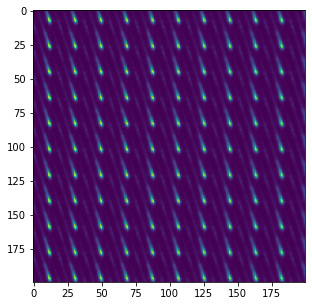

In [18]:
f = plt.figure(figsize=(5,5))
plt.imshow(raw[1200:1400,1200:1400])
plt.show()

## Cube up raw frame using simple aperture extraction - using trace on single spectrum... (need to generate more rectmats)

[2.9  2.91 2.92 2.93 2.94 2.95 2.96 2.97 2.98 2.99 3.   3.01 3.02 3.03
 3.04 3.05 3.06 3.07 3.08 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17
 3.18 3.19 3.2  3.21 3.22 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31
 3.32 3.33 3.34 3.35 3.36 3.37 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45
 3.46 3.47 3.48 3.49 3.5  3.51 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59
 3.6  3.61 3.62 3.63 3.64 3.65 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73
 3.74 3.75 3.76 3.77 3.78 3.79 3.8  3.81 3.82 3.83 3.84 3.85 3.86 3.87
 3.88 3.89 3.9  3.91 3.92 3.93 3.94 3.95 3.96 3.97 3.98 3.99 4.   4.01
 4.02 4.03 4.04 4.05 4.06 4.07 4.08 4.09 4.1  4.11 4.12 4.13 4.14 4.15] micron
(126, 2)


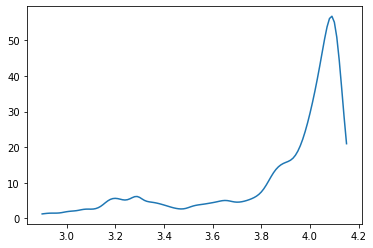

(341, 108, 108)


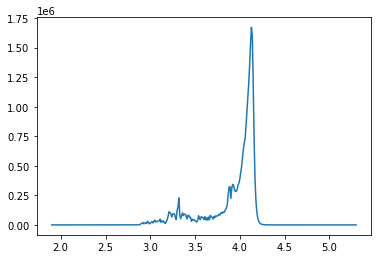

In [19]:
cinds = np.where(np.abs(fp.lam.value - lens.lmin)<1.0e-6)[0][0]
cinde = np.where(np.abs(fp.lam.value - lens.lmax)<1.0e-6)[0][0]
print(fp.lam[cinds:cinde+1])
specout = extract_using_trace(raw)
asf = 'filter_tests/asahi/ext_'+str(lens.lmin)+'_'+str(lens.lmax)+'.fits'
pyfits.writeto(asf,np.array(specout),clobber=True)
print(specout.shape)
plt.plot(specout[:,0],specout[:,1])
plt.show()

print(bg_star_truth.shape)
plt.plot(fp.lam,np.sum(np.sum(bg_star_truth,axis=-1),axis=-1))
plt.show()

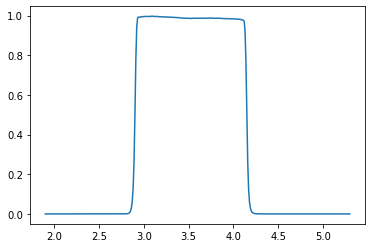

In [20]:
filtertrans = fp.Filter.interp(fp.lam)
plt.plot(fp.lam,filtertrans)
plt.show()

# Generate raw image and cube for andover filter

In [21]:
filt = Filter(fkw='andover',lmin=lens.lmin,lmax=lens.lmax)


####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

### Generate raw SCALES frame using  PSF (bkgd only)

In [22]:
rawfile = 'filter_tests/andover/raw_'+str(lens.lmin)+'_'+str(lens.lmax)+'.fits'
if os.path.isfile(rawfile)==False:
    raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,PSF=keck_cube,verbose=True)
    pyfits.writeto(rawfile,np.array(raw),clobber=True)
else: raw = pyfits.getdata(rawfile)

making full raw image
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


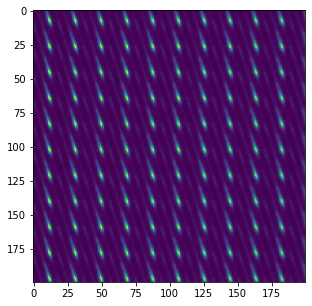

In [23]:
f = plt.figure(figsize=(5,5))
plt.imshow(raw[1200:1400,1200:1400])
plt.show()

## Cube up raw frame using simple aperture extraction - using trace on single spectrum... (need to generate more rectmats)

[2.9  2.91 2.92 2.93 2.94 2.95 2.96 2.97 2.98 2.99 3.   3.01 3.02 3.03
 3.04 3.05 3.06 3.07 3.08 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17
 3.18 3.19 3.2  3.21 3.22 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31
 3.32 3.33 3.34 3.35 3.36 3.37 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45
 3.46 3.47 3.48 3.49 3.5  3.51 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59
 3.6  3.61 3.62 3.63 3.64 3.65 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73
 3.74 3.75 3.76 3.77 3.78 3.79 3.8  3.81 3.82 3.83 3.84 3.85 3.86 3.87
 3.88 3.89 3.9  3.91 3.92 3.93 3.94 3.95 3.96 3.97 3.98 3.99 4.   4.01
 4.02 4.03 4.04 4.05 4.06 4.07 4.08 4.09 4.1  4.11 4.12 4.13 4.14 4.15] micron
(126, 2)


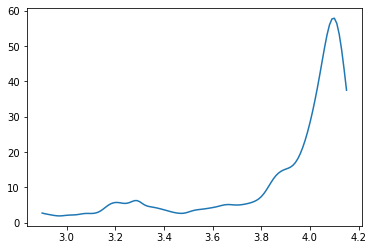

In [24]:
cinds = np.where(np.abs(fp.lam.value - lens.lmin)<1.0e-6)[0][0]
cinde = np.where(np.abs(fp.lam.value - lens.lmax)<1.0e-6)[0][0]
print(fp.lam[cinds:cinde+1])
specout = extract_using_trace(raw)
anf = 'filter_tests/andover/ext_'+str(lens.lmin)+'_'+str(lens.lmax)+'.fits'
pyfits.writeto(anf,np.array(specout),clobber=True)
print(specout.shape)
plt.plot(specout[:,0],specout[:,1])
plt.show()

#print(bg_star_truth.shape)
#plt.plot(fp.lam,np.sum(np.sum(bg_star_truth,axis=-1),axis=-1))
#plt.show()

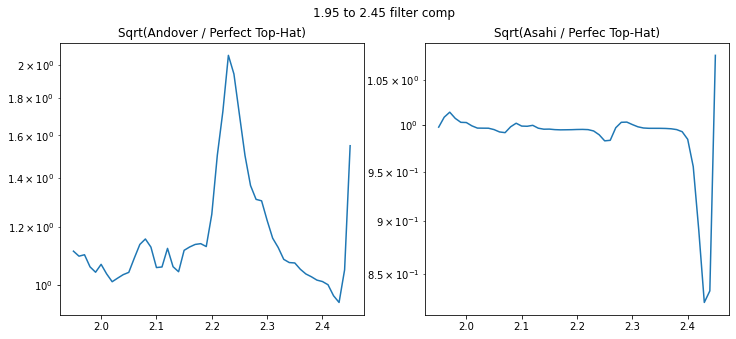

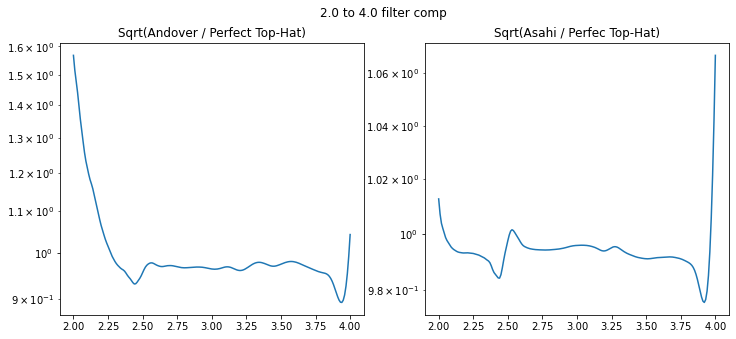

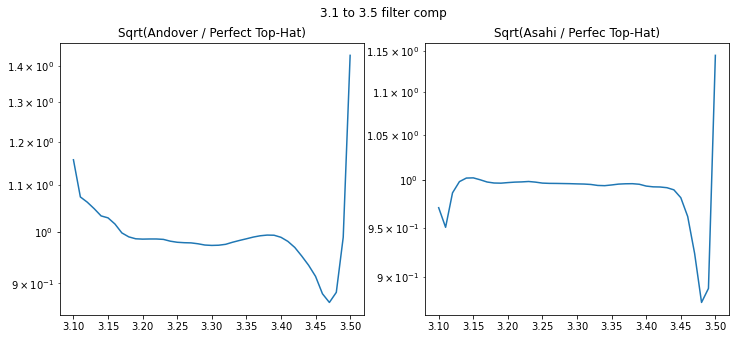

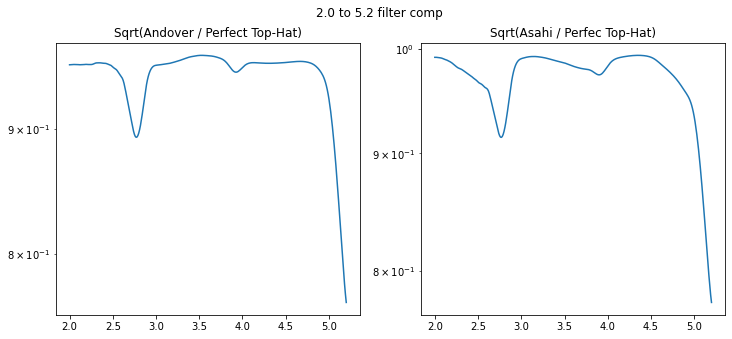

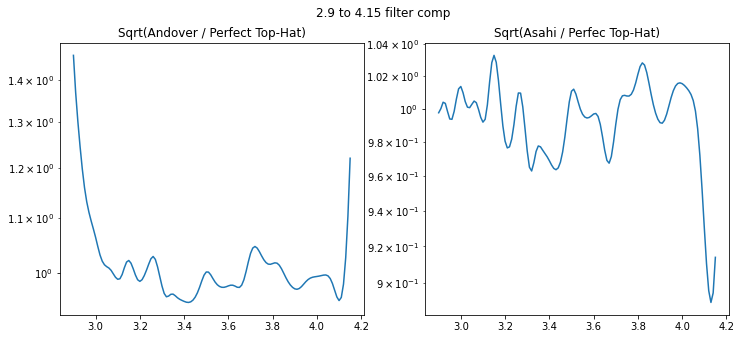

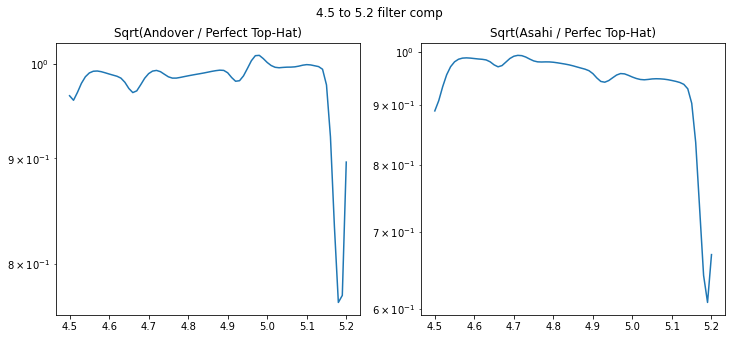

In [25]:
for lmin,lmax in [[1.95,2.45],[2.0,4.0],[3.1,3.5],[2.0,5.2],[2.9,4.15],[4.5,5.2]]:
    pf = 'filter_tests/perfect/ext_'+str(lmin)+'_'+str(lmax)+'.fits'
    anf = 'filter_tests/andover/ext_'+str(lmin)+'_'+str(lmax)+'.fits'
    asf = 'filter_tests/asahi/ext_'+str(lmin)+'_'+str(lmax)+'.fits'

    p = pyfits.getdata(pf)
    an = pyfits.getdata(anf)
    asa = pyfits.getdata(asf)

    #f = plt.figure()
    #f.add_subplot(131)
    #plt.plot(p[:,0],p[:,1])
    #f.add_subplot(132)
    #plt.plot(an[:,0],an[:,1])
    #f.add_subplot(133)
    #plt.plot(asa[:,0],asa[:,1])
    #plt.show()

    f = plt.figure(figsize=(12,5))
    f.suptitle(str(lmin)+' to '+str(lmax)+ ' filter comp')
    f.add_subplot(121)
    plt.title('Sqrt(Andover / Perfect Top-Hat)')
    plt.plot(p[:,0],np.sqrt(an[:,1]/p[:,1]))
    plt.yscale('log')
    f.add_subplot(122)
    plt.title('Sqrt(Asahi / Perfec Top-Hat)')
    plt.plot(p[:,0],np.sqrt(asa[:,1]/p[:,1]))
    plt.yscale('log')
    #plt.ylim(0.95,1.05)
    plt.savefig('filter_tests/fcomp_'+str(lmin)+'_'+str(lmax)+'.pdf')
    plt.show()



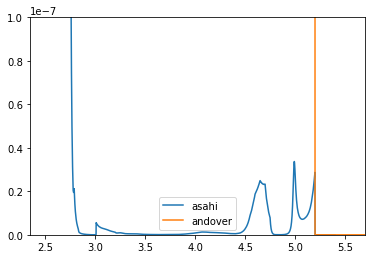

In [59]:
asahi = Filter(fkw='asahi',lmin=1.95,lmax=2.45)
andover = Filter(fkw='andover',lmin=1.95,lmax=2.45)
f = plt.figure()
plt.plot(asahi.x,asahi.y,label='asahi')
plt.plot(andover.x,andover.y,label='andover')
#plt.yscale('log')
plt.xlim(2.35,5.7)
plt.ylim(0.0,1.0e-7)
plt.legend()
plt.show()